In [1]:
from utils import (
    getMasterOutout,
    scale_intrinsics,
    CameraMatrix,
    run_pnp,
    getImageFromIndex,
    pnp_to_relative_global_coords,
    get_image_html,
    plot_images_on_map,
    create_orientation_arrow,
    plotImages,
    get_rotation_from_compass,
    getUTMzone
)

import matplotlib.pyplot as plt
import os
from PIL import Image


#ensuring i dont exceed cpu limits?
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

#supressing unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#imports for visualizing matches
import numpy as np

# Set your folder path
folder_path = '/home/bjangley/VPR/VPRMethods/sanity_check'
csv_path = '/home/bjangley/VPR/VPRMethods/sanity_check/metadata.csv'

In [2]:
import os
def count_images(folder_path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')
    return sum(1 for file in os.listdir(folder_path) if file.lower().endswith(image_extensions))

# Set your folder path
folder_path = '/home/bjangley/VPR/VPRMethods/sanity_check'
print(f'Total images:', count_images(folder_path))

"code to associate indices with pins (performed manually)"
pin_locations = [[51.989927, 4.344669], #manually recorded locations using google maps satellite view
                [51.989922, 4.344427],
                [51.989927, 4.344298],
                [51.989958, 4.344230],
                [51.989907, 4.343185],
                [51.989899, 4.342976],
                [51.989871, 4.342486],
                [51.989947, 4.342472],
                [51.989795, 4.339715],
                [51.989742, 4.339439],
                [51.989834, 4.339524],
                [51.989679, 4.339546],
                ]


##100 is a flag to show that I don't know which pin to map the image to, so we use the GPS location from 
##the metadata file in those cases. Otherwise the manual setting of image_to_pin is used as location
image_to_pin = [  0,  3,  2,  1,  2,  #array containing mapping from image index to pin
                  0,  2,  2,  3,  0,
                  4,100,  8,100,  9, #14
                100,100,  8,100, 11, #19
                  9,100, 11,100, 11, #24
                 11,  6,  8, 8, 100, #29
                100,  1,  1 
                ]

images_ex1 = [22,16,27,29,17]
images_ex2 = [19,14,18]
images_ex3 =[26,20,30]
images_ex4 =[10,30,31]
images_ex5 =[31,21,15]
images_ex6 = [8,7,1,6]


"Show the images in one experiment (used to localize each other)"
# plotImages(images_ex3, folder_path)


"Show all the images and/or pins in the dataset"
#plot_images_on_map(csv_path, folder_path, pin_locations, visualizePins=True, visualizeImages=True)





Total images: 33


'Show all the images and/or pins in the dataset'

>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Mast3r Inference Time: 0.3823 seconds.
Point Matches Time: 0.1860 seconds.
Number of matches before confidence mask:  341


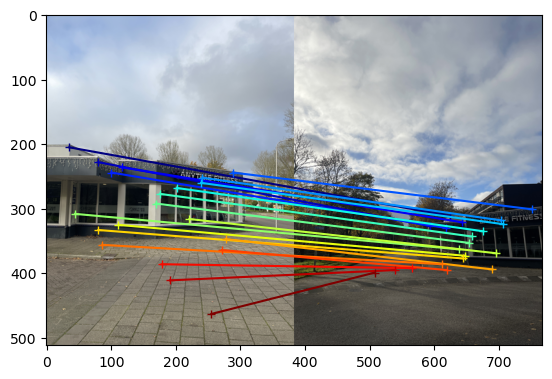

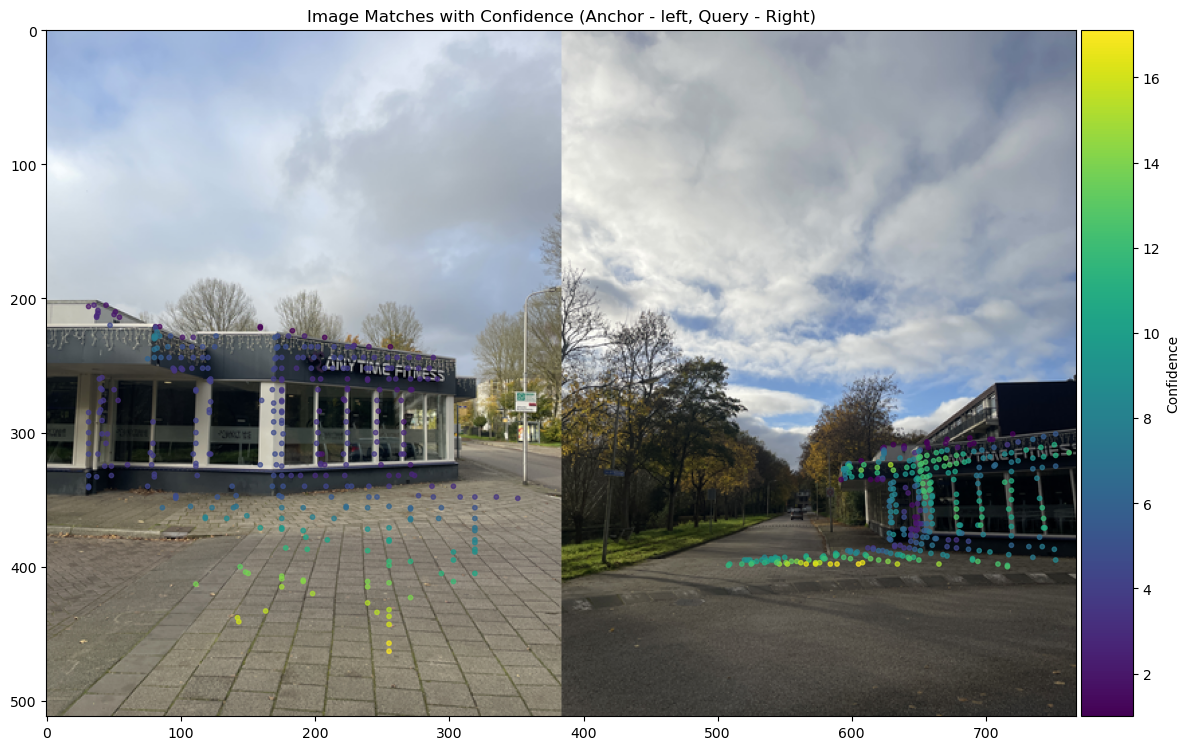

Number of matches after confidence mask:  56
Lowest Confidence Value:  9.655957 1.8396224


/home/bjangley/VPR/mast3r/utils.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


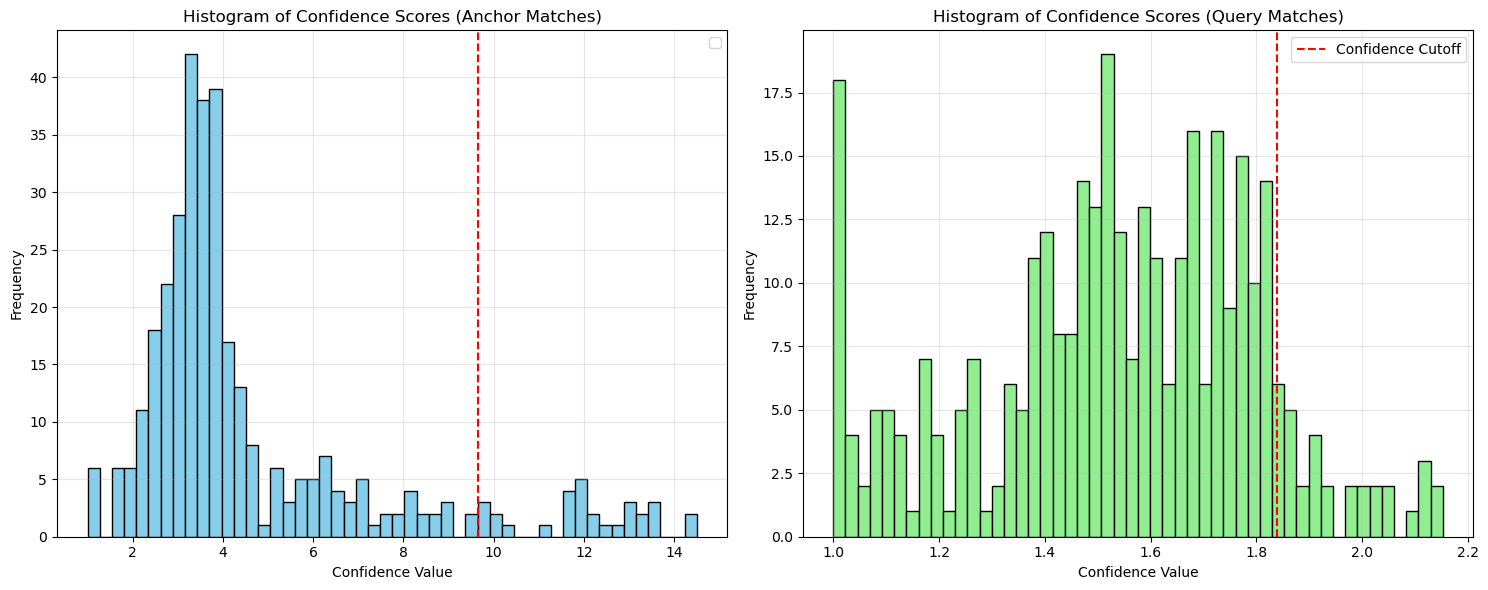

Predicted Transform:
 [14.17480543  0.54631038  3.87978321]
Translation Magnitude: 14.696184083432495
Estimated new position: Lat 51.98974687798613, Lon 4.339729598409084 



In [3]:
#input
scene = images_ex1
n_matches = 30
anchor= 0
query = 4


master_size = [512,384] #size of image used by mast3r
corrected_data=[]

anchor_index = scene[anchor] #get image index in metedatafile
anchor_image_dict, anchor_image_path_og = getImageFromIndex(anchor_index, folder_path)
anchor_image = Image.open(anchor_image_path_og)
anchor_image = anchor_image.rotate(-90, expand=True)
anchor_image_size = anchor_image.size  #original size of image

query_index = scene[query]
query_image_dict, query_image_path_og = getImageFromIndex(query_index,folder_path)
query_image = Image.open(query_image_path_og)
query_image = query_image.rotate(-90, expand=True)

anchor_image_path = '/home/bjangley/VPR/mast3r/sanity_check/anchor.png'
query_image_path = '/home/bjangley/VPR/mast3r/sanity_check/query.png'
anchor_image.save(anchor_image_path, format='PNG')
query_image.save(query_image_path, format='PNG')

# K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243) #landscape
# K_scaled = scale_intrinsics(K,known_image_size[1], known_image_size[0],master_size[0],master_size[1])

K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) #portrait
K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[1],master_size[0])

filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(anchor_image_path, query_image_path, n_matches,visualizeMatches=True)

# Predicted Transform copied from visloc.py
ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

if ret_val: 

    pnp_rotation = transformation[:3, :3]  
    pnp_translation = transformation[:3, 3]  
    print("Predicted Transform:\n", pnp_translation)    
    # Calculate and print the magnitude of the translation
    translation_magnitude = np.linalg.norm([pnp_translation[0],pnp_translation[2]])
    print("Translation Magnitude:", translation_magnitude)


    anchor_id = image_to_pin[int(anchor_image_dict['id'])]
    query_id = image_to_pin[int(query_image_dict['id'])]
    if anchor_id ==100:
        anchor_location = [float(anchor_image_dict['lat']),float(anchor_image_dict['long'])]
    else:
        anchor_location = pin_locations[anchor_id]
    

    if query_id ==100:
        query_location = [float(query_image_dict['lat']),float(query_image_dict['long'])]
    else:
        query_location = pin_locations[query_id]

    new_lat, new_lon, _ = pnp_to_relative_global_coords(pnp_rotation, 1*pnp_translation, anchor_location[0], anchor_location[1], float(anchor_image_dict['orientation']))
    print(f"Estimated new position: Lat {new_lat}, Lon {new_lon} \n")
    corrected_data.append([anchor_id,query_id,pnp_translation,new_lat, new_lon])

Anchor Location:  [51.989679, 4.339546]
Query Location:  [51.989795, 4.339715]
Corrected Location:  51.98974687798613 4.339729598409084



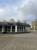
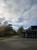

In [4]:
# Initialize the map
import folium
from owslib.wmts import WebMapTileService


# Define the URL for the PDOK WMTS service
url = "https://service.pdok.nl/hwh/luchtfotorgb/wmts/v1_0?request=GetCapabilities&service=wmts"

# Connect to the WMTS service
wmts = WebMapTileService(url)

# Inspect available layers
#print(wmts.contents)


i = 0
corrected_location = [corrected_data[i][3], corrected_data[i][4]]


# Add marker for anchor image
print("Anchor Location: ", anchor_location)
print("Query Location: ",query_location)
print("Corrected Location: ", corrected_data[i][3], corrected_data[i][4])



map_center = anchor_location
zoom_level = 20  # Desired zoom level
mymap = folium.Map(location=map_center, zoom_start=zoom_level, max_zoom=21)

# folium.TileLayer('Stamen Terrain').add_to(mymap)

# Manually construct the tile URL using the metadata from the WMTS service
# You need to use the correct layer, tilematrix set, and other parameters
tiles_url = (
    "https://service.pdok.nl/hwh/luchtfotorgb/wmts/v1_0?"
    "service=wmts&version=1.0.0&request=GetTile&layer=Actueel_ortho25"
    "&tilematrixset=EPSG:3857&tilematrix={z}&tilerow={y}&tilecol={x}&format=image/png"
)

# Add the tile layer to the Folium map
folium.TileLayer(
    tiles=tiles_url,
    attr="PDOK",
    name="Actueel Orthophoto",
    overlay=True
).add_to(mymap)

# Add layer control
folium.LayerControl().add_to(mymap)

anchor_html = get_image_html(anchor_image_path, rotate=False)
query_html = get_image_html(query_image_path, rotate=False)



# adding anchor
folium.Marker(
    location = anchor_location,
    popup=folium.Popup(anchor_html, max_width=300),
    icon=folium.Icon(color='blue'),
    tooltip="Anchor Image"
).add_to(mymap)
create_orientation_arrow(anchor_location, anchor_image_dict['orientation'], color='blue').add_to(mymap)


# adding query

folium.Marker(
    location=query_location,
    popup=folium.Popup(query_html, max_width=300),
    icon=folium.Icon(color='red'),
    tooltip="Query"
).add_to(mymap)

create_orientation_arrow(query_location, query_image_dict['orientation'], color='red').add_to(mymap)


#adding master localization
folium.Marker(
    location=corrected_location,
    icon=folium.Icon(color='green'),
    tooltip="MAST3R Localization"
).add_to(mymap)


# Create a legend HTML
legend_html = """
<div style="position: fixed; 
             bottom: 50px; left: 50px; 
             width: 180px; height: auto; 
             z-index:9999; font-size:14px; 
             background-color:white; 
             border:2px solid grey; 
             padding: 10px;">
    <b>Legend</b><br>
    <i class="fa fa-map-marker" style="color:blue"></i>&nbsp; Anchor<br>
    <i class="fa fa-map-marker" style="color:red"></i>&nbsp; Query<br>
    <i class="fa fa-map-marker" style="color:green"></i>&nbsp; MAST3R Localization<br>
</div>
"""

# Add the legend to the map using DivIcon
mymap.get_root().html.add_child(folium.Element(legend_html))

display(mymap)





In [5]:
# import folium
# from owslib.wmts import WebMapTileService

# # Define the URL for the PDOK WMTS service
# url = "https://service.pdok.nl/hwh/luchtfotorgb/wmts/v1_0?request=GetCapabilities&service=wmts"

# # Connect to the WMTS service
# wmts = WebMapTileService(url)

# # Inspect available layers
# print(wmts.contents)

# # Now, let's create a Folium map centered around a location (e.g., Amsterdam)
# m = folium.Map(location=[52.3676, 4.9041], zoom_start=12)

# # Manually construct the tile URL using the metadata from the WMTS service
# # You need to use the correct layer, tilematrix set, and other parameters
# tiles_url = (
#     "https://service.pdok.nl/hwh/luchtfotorgb/wmts/v1_0?"
#     "service=wmts&version=1.0.0&request=GetTile&layer=Actueel_ortho25"
#     "&tilematrixset=EPSG:3857&tilematrix={z}&tilerow={y}&tilecol={x}&format=image/png"
# )

# # Add the tile layer to the Folium map
# folium.TileLayer(
#     tiles=tiles_url,
#     attr="PDOK",
#     name="Actueel Orthophoto",
#     overlay=True
# ).add_to(m)

# # Add layer control
# folium.LayerControl().add_to(m)



# display(m)

Anchor Location:  [51.989679, 4.339546]
Query Location:  [51.989795, 4.339715]
Corrected Location:  51.98974687798613 4.339729598409084



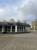
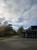

In [6]:

# Initialize the map
import folium
from owslib.wmts import WebMapTileService

from pyproj import Proj, transform

#pointmap = pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :]
pointmap = pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :]
# pointmap = pts3d_im0[conf_im0>8].reshape(-1, 3)
compass_angle = float(anchor_image_dict['orientation'])
compass_rotation = get_rotation_from_compass(np.deg2rad(compass_angle))
R_cam_to_world = np.array([[1, 0, 0],
                            [0, 0, 1],
                            [0, -1, 0]])


transformed_points = (R_cam_to_world @ pointmap.T).T

# Then apply the inverse of compass rotation
final_transformed_points_anchor = (np.linalg.inv(compass_rotation) @ transformed_points.T).T

#pointmap = pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :]
pointmap_query = pts3d_im1[matches_im1[:, 1], matches_im1[:, 0], :]
# pointmap = pts3d_im0[conf_im0>8].reshape(-1, 3)
compass_angle = float(query_image_dict['orientation'])
compass_rotation = get_rotation_from_compass(np.deg2rad(compass_angle))
R_cam_to_world = np.array([[1, 0, 0],
                            [0, 0, 1],
                            [0, -1, 0]])


transformed_points_query = (R_cam_to_world @ pointmap_query.T).T

# Then apply the inverse of compass rotation
final_transformed_points_query = (np.linalg.inv(compass_rotation) @ transformed_points_query.T).T




# Define the URL for the PDOK WMTS service
url = "https://service.pdok.nl/hwh/luchtfotorgb/wmts/v1_0?request=GetCapabilities&service=wmts"

# Connect to the WMTS service
wmts = WebMapTileService(url)

# Inspect available layers
#print(wmts.contents)


i = 0
corrected_location = [corrected_data[i][3], corrected_data[i][4]]


# Add marker for anchor image
print("Anchor Location: ", anchor_location)
print("Query Location: ",query_location)
print("Corrected Location: ", corrected_data[i][3], corrected_data[i][4])



map_center = anchor_location
zoom_level = 20  # Desired zoom level
mymap = folium.Map(location=map_center, zoom_start=zoom_level, max_zoom=21, control_scale=True)

# folium.TileLayer('Stamen Terrain').add_to(mymap)

# Manually construct the tile URL using the metadata from the WMTS service
# You need to use the correct layer, tilematrix set, and other parameters
tiles_url = (
    "https://service.pdok.nl/hwh/luchtfotorgb/wmts/v1_0?"
    "service=wmts&version=1.0.0&request=GetTile&layer=Actueel_ortho25"
    "&tilematrixset=EPSG:3857&tilematrix={z}&tilerow={y}&tilecol={x}&format=image/png"
)

# Add the tile layer to the Folium map
folium.TileLayer(
    tiles=tiles_url,
    attr="PDOK",
    name="Actueel Orthophoto",
    overlay=True,
    # max_native_zoom=14,  # Set this to the maximum zoom level supported by your tiles
    # min_native_zoom=10,   # Set minimum zoom level as necessary
    max_zoom=21   
).add_to(mymap)

# Add layer control
folium.LayerControl().add_to(mymap)

anchor_html = get_image_html(anchor_image_path, rotate=False)
query_html = get_image_html(query_image_path, rotate=False)



# adding anchor
folium.Marker(
    location = anchor_location,
    popup=folium.Popup(anchor_html, max_width=300),
    icon=folium.Icon(color='blue'),
    tooltip="Anchor Image"
).add_to(mymap)
create_orientation_arrow(anchor_location, anchor_image_dict['orientation'], color='blue').add_to(mymap)


# adding query

folium.Marker(
    location=query_location,
    popup=folium.Popup(query_html, max_width=300),
    icon=folium.Icon(color='red'),
    tooltip="Query"
).add_to(mymap)

create_orientation_arrow(query_location, query_image_dict['orientation'], color='red').add_to(mymap)


#adding master localization
folium.Marker(
    location=corrected_location,
    icon=folium.Icon(color='green'),
    tooltip="MAST3R Localization"
).add_to(mymap)



# Step 1: Convert anchor location to UTM
utm_proj = Proj(proj='utm', zone=getUTMzone(anchor_location[1]), ellps='WGS84')   # Adjust zone based on your area
anchor_utm_x, anchor_utm_y = utm_proj(anchor_location[1], anchor_location[0])  # lon, lat 

# Now add all points from pointmap to the Folium map
for point in final_transformed_points_anchor:
    # Assuming point is in format [x, y, z] where x and y are offsets from anchor in meters
    x_offset, y_offset, z = point  # Unpack the point coordinates
    
    # Step 2: Apply translations in UTM coordinates
    translated_utm_x = anchor_utm_x + x_offset
    translated_utm_y = anchor_utm_y + y_offset
    
    # Step 3: Convert back to latitude and longitude from UTM
    lon, lat = utm_proj(translated_utm_x, translated_utm_y, inverse=True)  # Convert back to lat/lon

    # Step 4: Add marker for each translated point on the map
    # folium.Marker(
    #     location=[lat, lon],
    #     icon=folium.Icon(color='purple'),  # Color for pointmap markers
    #     tooltip=f"Point: ({x_offset}, {y_offset}, {z})"  # Tooltip showing original coordinates
    # ).add_to(mymap)

    folium.CircleMarker(
    location=[lat, lon],
    radius=5,  # Adjust the radius as needed
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6,
    tooltip=f"Point: ({x_offset}, {y_offset})"  # Tooltip showing coordinates
    ).add_to(mymap)


# query_utm_x, query_utm_y = utm_proj(query_location[1], query_location[0])
# # Now add all points from pointmap to the Folium map
# for point in final_transformed_points_query:
#     # Assuming point is in format [x, y, z] where x and y are offsets from anchor in meters
#     x_offset, y_offset, z = point  # Unpack the point coordinates
    
#     # Step 2: Apply translations in UTM coordinates
#     translated_utm_x = query_utm_x + x_offset
#     translated_utm_y = query_utm_y + y_offset
    
#     # Step 3: Convert back to latitude and longitude from UTM
#     lon, lat = utm_proj(translated_utm_x, translated_utm_y, inverse=True)  # Convert back to lat/lon

#     # Step 4: Add marker for each translated point on the map
#     # folium.Marker(
#     #     location=[lat, lon],
#     #     icon=folium.Icon(color='purple'),  # Color for pointmap markers
#     #     tooltip=f"Point: ({x_offset}, {y_offset}, {z})"  # Tooltip showing original coordinates
#     # ).add_to(mymap)

#     folium.CircleMarker(
#     location=[lat, lon],
#     radius=5,  # Adjust the radius as needed
#     color='red',
#     fill=True,
#     fill_color='red',
#     fill_opacity=0.6,
#     tooltip=f"Point: ({x_offset}, {y_offset})"  # Tooltip showing coordinates
#     ).add_to(mymap)



# Create a legend HTML
legend_html = """
<div style="position: fixed; 
             bottom: 50px; left: 50px; 
             width: 180px; height: auto; 
             z-index:9999; font-size:14px; 
             background-color:white; 
             border:2px solid grey; 
             padding: 10px;">
    <b>Legend</b><br>
    <i class="fa fa-map-marker" style="color:blue"></i>&nbsp; Anchor<br>
    <i class="fa fa-map-marker" style="color:red"></i>&nbsp; Query<br>
    <i class="fa fa-map-marker" style="color:green"></i>&nbsp; MAST3R Localization<br>
</div>
"""

# Add the legend to the map using DivIcon
mymap.get_root().html.add_child(folium.Element(legend_html))


# Save the map to an HTML file
mymap.save("my_map.html")



display(mymap)








In [7]:
print(pointmap)

[[-3.8101432  -1.2453516   8.491344  ]
 [-3.8339722  -1.3188382   9.107773  ]
 [-3.8819282  -1.213834    8.425606  ]
 ...
 [ 0.5785368   1.7135224   3.2120066 ]
 [ 0.52830726  1.6818614   2.9286087 ]
 [ 0.5093423   1.6686206   2.8213494 ]]


In [8]:
print(transformed_points)

[[-3.81014323  8.49134445  1.24535155]
 [-3.83397222  9.10777283  1.31883824]
 [-3.88192821  8.42560577  1.21383405]
 ...
 [ 0.57853681  3.21200657 -1.71352243]
 [ 0.52830726  2.92860866 -1.6818614 ]
 [ 0.50934231  2.82134938 -1.66862059]]
